**Artificial Inteligence (CS550)**
<br>
Date: **30 March 2021**
<br>


Title: **Seminar 16 - Part C**

Speaker: **Dr. Shota Tsiskaridze**


Bibliography: 
<br>
[1] **Chapter 11**, Jeremy Howard & Sylvain Gugger, Deep Learning for Coders with fastai & PyTorch, O'Reilly Media, Inc., 2020

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from IPython.display import display,HTML

## Applying the Mid-Level Data API: SiamesePair

A *Siamese model* takes two images and has to determine if they are of the same class or not. For this example, we will use the Pet dataset again and prepare the data for a model that will have to predict if two images of pets are of the same breed or not. We will explain here how to prepare the data for such a model, then we will train that model in <<chapter_arch_details>>.

First things first, let's get the images in our dataset:

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

If we didn't care about showing our objects at all, we could directly create one transform to completely preprocess that list of files. We will want to look at those images though, so we need to create a custom type. When you call the `show` method on a `TfmdLists` or a `Datasets` object, it will decode items until it reaches a type that contains a `show` method and use it to show the object. That `show` method gets passed a `ctx`, which could be a `matplotlib` axis for images, or a row of a DataFrame for texts.

Here we create a `SiameseImage` object that subclasses `fastuple` and is intended to contain three things: two images, and a Boolean that's `True` if the images are of the same breed. We also implement the special `show` method, such that it concatenates the two images with a black line in the middle. Don't worry too much about the part that is in the `if` test (which is to show the `SiameseImage` when the images are Python images, not tensors); the important part is in the last three lines:

In [4]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

Let's create a first `SiameseImage` and check our `show` method works:

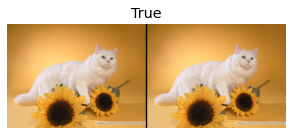

In [5]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

We can also try with a second image that's not from the same class:

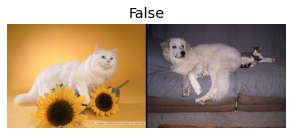

In [6]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

The important thing with transforms that we saw before is that they dispatch over tuples or their subclasses. That's precisely why we chose to subclass `fastuple` in this instance—this way we can apply any transform that works on images to our `SiameseImage` and it will be applied on each image in the tuple:

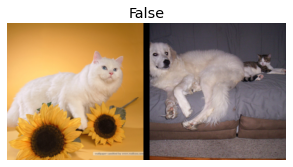

In [7]:
s2 = Resize(224)(s1)
s2.show();

Here the `Resize` transform is applied to each of the two images, but not the Boolean flag. Even if we have a custom type, we can thus benefit from all the data augmentation transforms inside the library.

We are now ready to build the `Transform` that we will use to get our data ready for a Siamese model. First, we will need a function to determine the classes of all our images:

In [8]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

For each image our tranform will, with a probability of 0.5, draw an image from the same class and return a `SiameseImage` with a true label, or draw an image from another class and return a `SiameseImage` with a false label. This is all done in the private `_draw` function. There is one difference between the training and validation sets, which is why the transform needs to be initialized with the splits: on the training set we will make that random pick each time we read an image, whereas on the validation set we make this random pick once and for all at initialization. This way, we get more varied samples during training, but always the same validation set:

In [9]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

We can then create our main transform:

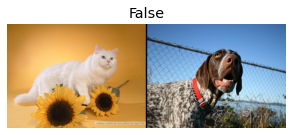

In [10]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

In the mid-level API for data collection we have two objects that can help us apply transforms on a set of items, `TfmdLists` and `Datasets`. If you remember what we have just seen, one applies a `Pipeline` of transforms and the other applies several `Pipeline`s of transforms in parallel, to build tuples. Here, our main transform already builds the tuples, so we use `TfmdLists`:

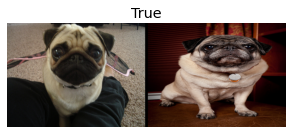

In [11]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

And we can finally get our data in `DataLoaders` by calling the `dataloaders` method. One thing to be careful of here is that this method does not take `item_tfms` and `batch_tfms` like a `DataBlock`. The fastai `DataLoader` has several hooks that are named after events; here what we apply on the items after they are grabbed is called `after_item`, and what we apply on the batch once it's built is called `after_batch`:

In [12]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Note that we need to pass more transforms than usual—that's because the data block API usually adds them automatically:

- `ToTensor` is the one that converts images to tensors (again, it's applied on every part of the tuple).
- `IntToFloatTensor` converts the tensor of images containing integers from 0 to 255 to a tensor of floats, and divides by 255 to make the values between 0 and 1.

We can now train a model using this `DataLoaders`. It will need a bit more customization than the usual model provided by `cnn_learner` since it has to take two images instead of one, but we will see how to create such a model and train it in <<chapter_arch_dtails>>.